<a href="https://colab.research.google.com/github/JudsonLima/computationalImaging/blob/master/HW5_JudsonLimaFinal_Multiplane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Imaging HW 5 multiplane objects

Judson Lima

OPTI 556, Fall 2023

## Objective

Reconstruction of objects that exist at more than one depth and an approach to a neural estimator for multiplane objects was done.

##Libraries

In [62]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
import torch.optim as optim
import math
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import sys
from PIL import Image

import numpy as np
import cv2 as cv
plt.style.use('default')
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams.update({'font.size': 18})

from scipy.integrate import simpson
import IPython.display as Idisplay

In [4]:
%pip install "git+https://github.com/farhadnkm/Fringe.Py"

  Cloning https://github.com/farhadnkm/Fringe.Py to /tmp/pip-req-build-_390pt_1
  Running command git clone --filter=blob:none --quiet https://github.com/farhadnkm/Fringe.Py /tmp/pip-req-build-_390pt_1
  Resolved https://github.com/farhadnkm/Fringe.Py to commit f40c4251b641ca2e1747f0e7be98dea7ded0d62d
  Preparing metadata (setup.py) ... done
  Created wheel for fringe: filename=fringe-1.0.7-py2.py3-none-any.whl size=16327 sha256=316cc6e326d238917e123001866b87594f503d001371641f670c3ef853b02564
  Stored in directory: /tmp/pip-ephem-wheel-cache-dxru7j8g/wheels/9c/fb/3f/c9f11bd79bb2ffb799462aa5890cda9cd0ecdfaf0b6d08d28d
Successfully built fringe


In [5]:
%pip install "git+https://github.com/TylerYep/torchinfo"

  Cloning https://github.com/TylerYep/torchinfo to /tmp/pip-req-build-salf_mhb
  Running command git clone --filter=blob:none --quiet https://github.com/TylerYep/torchinfo /tmp/pip-req-build-salf_mhb
  Resolved https://github.com/TylerYep/torchinfo to commit 0f8e78a20bf36b7a69cae386e12e8001a7cd8d86
  Preparing metadata (setup.py) ... done
  Created wheel for torchinfo: filename=torchinfo-1.8.0-py3-none-any.whl size=23385 sha256=ddb237315463acde80e79925a8c6ad8e46203c0b2655200ad3219c9adb829ffc
  Stored in directory: /tmp/pip-ephem-wheel-cache-v62cg26d/wheels/f4/fc/1c/6ad80eb18f46b873fb598bbe65d6af321de92fb957014e07cf
Successfully built torchinfo


In [6]:
%pip install torchinfo

In [7]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
from torchinfo import summary

from fringe.utils.io import import_image
from fringe.utils.modifiers import ImageToArray, Normalize, MakeComplex
from fringe.solvers.AngularSpectrum import AngularSpectrumSolver as AsSolver



load MNIST validation dataset

In [9]:
MNIST = torchvision.datasets.MNIST(root='./', train=0, download=1)

100%|██████████| 9912422/9912422 [00:00<00:00, 91488192.55it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21814459.54it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28967327.04it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18658696.15it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### Metrics functions

In [63]:
def psnr_ssim(img_true, preds):
    psnr_comparsion = psnr(
            image_true=img_true,
            image_test=preds,
            data_range=1.0
        )

    # structural similarity index measure
    ssim_comparsion = ssim(
        im1=img_true,
        im2=preds,
        data_range=1.0,
        gaussian_weights=True,
        sigma = 1.5,
        use_sample_covariance=False
    )
    return psnr_comparsion,ssim_comparsion

## Setup for 3D model

### system parameters

pixel pitch = 2μm

wavelength = 532nm

Amplitude of illumination plane-wave = 10 A.U.

In [23]:
pixel_pitch = 2 # μm
wavelength = 532e-3 # μm
r = 10 # illumination plane wave-field
lam = wavelength/pixel_pitch
# N is image size, e.g. 512x512 256x256

### Other functions

In [11]:
def asm_custom(f, z, wavelength, pixel_pitch, only_CTF=False,
               fix_padding=False, padding=None, crop2size=False):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
#
    d = z/wavelength
    lam = wavelength/pixel_pitch
    if lam >= 1:
        print('aliasing in the simulated diffracted field!')
#     zPad = int(np.abs(d)*lam/4)
    if fix_padding:
        zPad = padding
    else:
        zPad = int(np.abs(z)*wavelength/pixel_pitch)

    inF = np.zeros(np.add(f.shape, [zPad,zPad])).astype(complex)
    inF[int(inF.shape[0]/2-f.shape[0]/2):int(inF.shape[0]/2+f.shape[0]/2),
        int(inF.shape[0]/2-f.shape[0]/2):int(inF.shape[0]/2+f.shape[0]/2)] = f
#     urange = np.linspace(-lam/2,lam/2,inF.shape[0])
    urange = np.linspace(-1/(2*pixel_pitch),1/(2*pixel_pitch),inF.shape[0])
    u,v = np.meshgrid(urange, urange)
#     CTF = np.exp(1j *2* np.pi * (z/wavelength) *np.sqrt(1 - u**2 - v**2))
    CTF = np.exp(1j *2* np.pi * (d) *np.sqrt(1 - (u*wavelength)**2 - (v*wavelength)**2))

    if only_CTF:
        return CTF
    else:
        inf_fft = np.fft.fftshift(np.fft.fft2(inF))
        output_field = np.fft.ifft2(np.fft.ifftshift(inf_fft*CTF))
        return output_field, CTF

def asm_fringe(input_field:complex, z:float, wavelength:float, pixel_pitch:float,
               padding='same') -> 'complex output field':
    '''
    input_field:
    z: propogation distance in μm
    pixel_pitch: pixel pitch in μm
    padding
    wavelength: wavelength in μm

    output_field:
    '''
    if padding != 'same':
        padding=[[[input_field.shape[0]]*2],[[input_field.shape[1]]*2]]
    # Initialize Angular Spectrum Solver
    solver = AsSolver(shape=input_field.shape, dr=pixel_pitch, is_batched=False,
                      padding=padding, pad_fill_value=0, backend='numpy')
    output_field = solver.solve(input_=input_field, k=2 * np.pi/wavelength, z=z)

    return output_field

In [12]:
def holo_prop(input_field, z, r, N):
    CTF = asm_custom(input_field, z, wavelength, pixel_pitch, only_CTF=True, fix_padding=True, padding=0)
    psf = np.fft.ifft2(np.fft.ifftshift(CTF))
    x = np.linspace(-N*pixel_pitch/2, N*pixel_pitch/2, N+1)
    x = x[:-1]
    # del_x = x[1]-x[0]
    y = np.linspace(-N*pixel_pitch/2, N*pixel_pitch/2, N+1)
    y = y[:-1]
    # del_y = y[1]-y[0]
    c = simpson(simpson(psf, y), x)
    f = 1/c*(r**2) + np.conjugate(r)*input_field
    f_fft = np.fft.fftshift(np.fft.fft2(f))
    output_field = np.fft.ifft2(np.fft.ifftshift(CTF*f_fft))

    return output_field

In [13]:
def holo_multi_depth(input_field, z, z_pos_list, r, holo_prop, N):
    output_field = np.zeros(np.shape(input_field)).astype(complex)
    for z_pos in z_pos_list:
        output_field[..., np.where(z==z_pos)[0][0]] = holo_prop(input_field[...,np.where(z==z_pos)[0][0]],
                                                                z_pos, r, N)

    output_field = np.array(output_field)
    output_field = np.reshape(output_field, np.shape(input_field))
    output_field = np.sum(output_field, axis=-1)

    return output_field

### Forward_Model class
initialize a Forward_Model object (tensor)

ASM (tensor)

hologram for 2D object (2D data, tensor)

hologram for 3D object (3D datacube, tensor)

In [14]:
class Forward_Model(nn.Module):

    def __init__(self, r, N, wavelength, pixel_pitch, single_depth=True):
        super(Forward_Model, self).__init__()
        ## initialize
        self.cuda_device = "cuda" if torch.cuda.is_available() else "cpu"
#         self.input_field = torch.tensor(input_field, dtype=torch.complex64, device=self.cuda_device)
        self.wavelength = wavelength
        self.pixel_pitch = pixel_pitch
#         self.z = z
        self.r = r
        self.N = N
#         self.z_pos_list = z_pos_list
        self.single_depth = single_depth
        if self.single_depth:
            self.multi_depth = False
        else:
            self.multi_depth = True


    def asm_custom(self, f, z_pos, only_CTF=False, fix_padding=False, padding=None, crop2size=False):
    #
    # calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
    # d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
    #
        z = z_pos
        d = z/self.wavelength
        lam = self.wavelength/self.pixel_pitch
        if lam >= 1:
            print('aliasing in the simulated diffracted field!')
    #     zPad = int(np.abs(d)*lam/4)
        if fix_padding:
            zPad = padding
        else:
            zPad = int(np.abs(z)*self.wavelength/self.pixel_pitch)

    #     urange = np.linspace(-lam/2,lam/2,inF.shape[0])
        inF = torch.zeros(tuple(np.add(f.shape[2:4],[zPad,zPad])))
        inF = torch.reshape(inF, [1,1,inF.shape[0], inF.shape[1]])

        urange = torch.linspace(-1/(2*self.pixel_pitch), 1/(2*self.pixel_pitch), inF.shape[2])
        u,v = torch.meshgrid(urange, urange, indexing='ij')
    #     CTF = np.exp(1j *2* np.pi * (z/wavelength) *np.sqrt(1 - u**2 - v**2))
        CTF = torch.exp(1j *2* np.pi * z *torch.sqrt(1/self.wavelength**2 - u**2 - v**2))
#         np.exp(1j *2* np.pi * z *np.sqrt(1/wavelength**2 - u**2 - v**2))
        CTF = torch.reshape(CTF, [1,1,CTF.shape[0], CTF.shape[1]])
        CTF = CTF.to(dtype=torch.complex64, device=self.cuda_device)

        if only_CTF:
            if crop2size:
                CTF = CTF[0,0,zPad//2:zPad//2+self.N, zPad//2:zPad//2+self.N]
                CTF = torch.reshape(CTF, [1,1,self.N,self.N])
            return CTF
        else:
            inF = inF.to(dtype=torch.complex64, device=self.cuda_device)
            inF[0,0,int(inF.shape[2]/2-f.shape[2]/2):int(inF.shape[2]/2+f.shape[2]/2),
                    int(inF.shape[3]/2-f.shape[3]/2):int(inF.shape[3]/2+f.shape[3]/2)] = f[0,0]
            inF_fft = torch.fft.fftshift(torch.fft.fft2(inF))
            output_field = torch.fft.ifft2(torch.fft.ifftshift(inF_fft*CTF))
            output_field = output_field.to(dtype=torch.complex64, device=self.cuda_device)
            if crop2size:
                output_field = output_field[0, 0, zPad//2:zPad//2+self.N, zPad//2:zPad//2+self.N]
                CTF = CTF[0, 0, zPad//2:zPad//2+self.N, zPad//2:zPad//2+self.N]
                CTF = torch.reshape(CTF, [1,1,self.N,self.N])
                output_field = torch.reshape(output_field, [1,1,self.N,self.N])

            return output_field, CTF


    def holo_prop(self, input_field, z_pos,
                  crop2size=False, padding_size=0, exact_form=False):
        input_field = input_field.to(device=self.cuda_device)
        output_field, CTF = self.asm_custom(input_field, z_pos, only_CTF=False,
                                            fix_padding=True, padding=padding_size, crop2size=False)
        if crop2size:
            output_field = output_field[0,0,
                                        padding_size//2:padding_size//2+self.N,
                                        padding_size//2:padding_size//2+self.N]
        output_field = torch.reshape(output_field, [1,1,self.N,self.N])

        if not exact_form:
            hologram = torch.real(self.r**2 + 2*np.conj(self.r)*output_field)
        else:
            hologram = torch.abs(self.r + output_field)**2

        hologram = hologram.to(dtype=torch.float32, device=self.cuda_device)
        return hologram


    def holo_multi_depth(self, input_field, z, z_pos_list,
                         crop2size=False, padding_size=0, exact_form=False):

        output_field = torch.zeros((input_field).shape, dtype=torch.complex64)

        for z_pos in z_pos_list:
            input_field_slice = torch.reshape(input_field[0, np.where(z==z_pos)[0][0],...], [1,1,self.N,self.N])
            output_field[0, np.where(z==z_pos)[0][0],...],_ =\
                                    self.asm_custom(input_field_slice, z_pos, only_CTF=False,
                                                    fix_padding=True, padding=padding_size, crop2size=False)

            if crop2size:
                output_field = output_field[0, np.where(z==z_pos)[0][0],
                                            padding_size//2:padding_size//2+self.N,
                                            padding_size//2:padding_size//2+self.N]


        output_field = torch.sum(output_field, axis=1)
        output_field = torch.reshape(output_field, [1,1,self.N,self.N])
        if not exact_form:
            hologram = torch.real(self.r**2 + 2*np.conj(self.r)*output_field)
        else:
            hologram = torch.abs(self.r + output_field)**2
        hologram = hologram.to(dtype=torch.float32, device=self.cuda_device)
        return hologram

## multi-depth amplitude object

### Resconstructed without neural estimator

size: 256x256x3 at (1000, 1250, 2000)
μm

In [24]:
z_slice = 3
# z = np.linspace(500, 1900, z_slice)
z = np.arange(1000, 1500+1, 250).astype('float32')
z_pos_list = z
N = 256
r = 10
save_name_prefix = 'multidepthMnist02'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
z

array([1000., 1250., 1500.], dtype=float32)

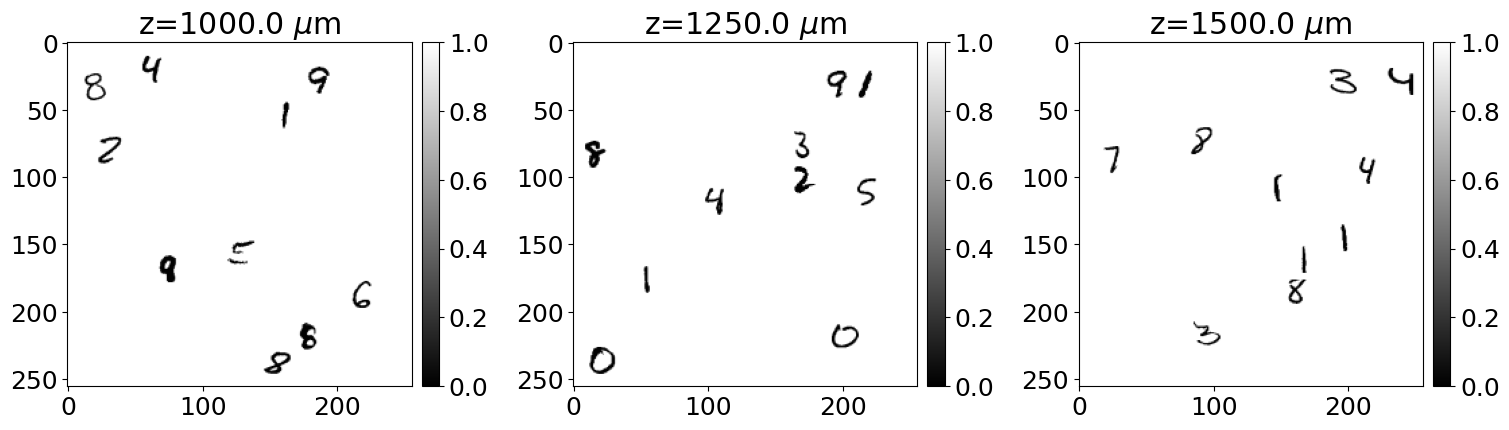

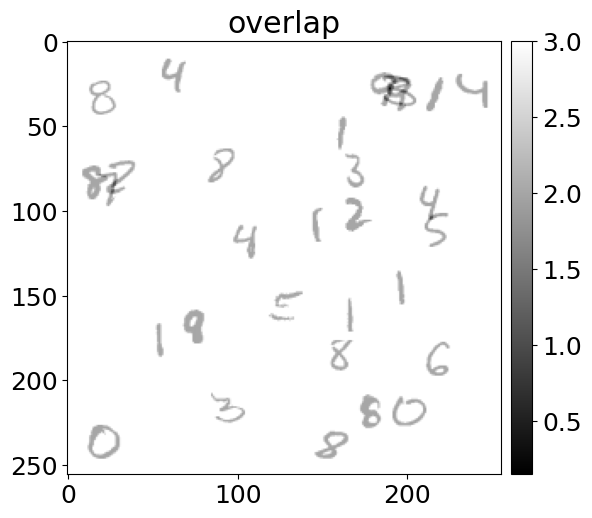

In [25]:
input_field = np.zeros([1,len(z),N,N]).astype('float32')
scale = 1
# i = 0
for z_pos in z_pos_list:
    try:
        x = np.random.randint(N//2)
        y = np.random.randint(N//2)
        letter = np.array(MNIST[np.random.randint(1000)][0]).astype(float)
        letter = cv.resize(letter, [28*scale]*2)
        letter = letter/np.max(letter)
        input_field[0, np.where(z==z_pos)[0][0],
                    x:x+28*scale, y:y+28*scale] = letter
        x = np.random.randint(N//2,N-28*scale)
        y = np.random.randint(N//2)
        letter = np.array(MNIST[np.random.randint(1000)][0]).astype(float)
        letter = cv.resize(letter, [28*scale]*2)
        letter = letter/np.max(letter)
        input_field[0, np.where(z==z_pos)[0][0],
                    x:x+28*scale, y:y+28*scale] = letter
        x = np.random.randint(N//2)
        y = np.random.randint(N//2,N-28*scale)
        letter = np.array(MNIST[np.random.randint(1000)][0]).astype(float)
        letter = cv.resize(letter, [28*scale]*2)
        letter = letter/np.max(letter)
        input_field[0, np.where(z==z_pos)[0][0],
                    x:x+28*scale, y:y+28*scale] = letter
        x = np.random.randint(N//2,N-28*scale)
        y = np.random.randint(N//2,N-28*scale)
        letter = np.array(MNIST[np.random.randint(1000)][0]).astype(float)
        letter = cv.resize(letter, [28*scale]*2)
        letter = letter/np.max(letter)
        input_field[0, np.where(z==z_pos)[0][0],
                    x:x+28*scale, y:y+28*scale] = letter
        for j in range(6):
            x = np.random.randint(N-28*scale)
            y = np.random.randint(N-28*scale)
            letter = np.array(MNIST[np.random.randint(1000)][0]).astype(float)
            letter = cv.resize(letter, [28*scale]*2)
            letter = letter/np.max(letter)
            input_field[0, np.where(z==z_pos)[0][0],
                        x:x+28*scale, y:y+28*scale] = letter

#     input_field[0,np.where(z==z_pos)[0][0],
#                 int(N/2-14)-64+25*i:int(N/2+14)-64+25*i,
#                 int(N/2-14)-64+25*i:int(N/2+14)-64+25*i,] = np.array(MNIST[np.random.randint(1000)][0])/255.
#     input_field[0,np.where(z==z_pos)[0][0],
#                 int(N/2-14)-32+25*i:int(N/2+14)-32+25*i,
#                 int(N/2-14)-32+25*i:int(N/2+14)-32+25*i,] = np.array(MNIST[np.random.randint(1000)][0])/255.
#     input_field[0,np.where(z==z_pos)[0][0],
#                 int(N/2-14)-0+25*i:int(N/2+14)-0+25*i,
#                 int(N/2-14)-0+25*i:int(N/2+14)-0+25*i,] = np.array(MNIST[np.random.randint(1000)][0])/255.
#         i += 1
    except:
        continue

input_field = 1-input_field
plt.figure(figsize=[20,10])
for i in range(len(z)):
    plt.subplot(2,4,1+i)
    im = plt.imshow(abs(input_field[0,i,...]))
    plt.title(f'z={z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    plt.gray()


plt.tight_layout()
plt.show()

plt.figure()
im = plt.imshow(np.sum(abs(input_field[0,...]), axis=0))
plt.title('overlap')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
plt.show()
input_field = torch.tensor(input_field)
input_field = input_field.to(dtype=torch.complex64, device=DEVICE)

In [26]:
padding_size = int(np.max(z)*wavelength/pixel_pitch/pixel_pitch)
padding_size

199

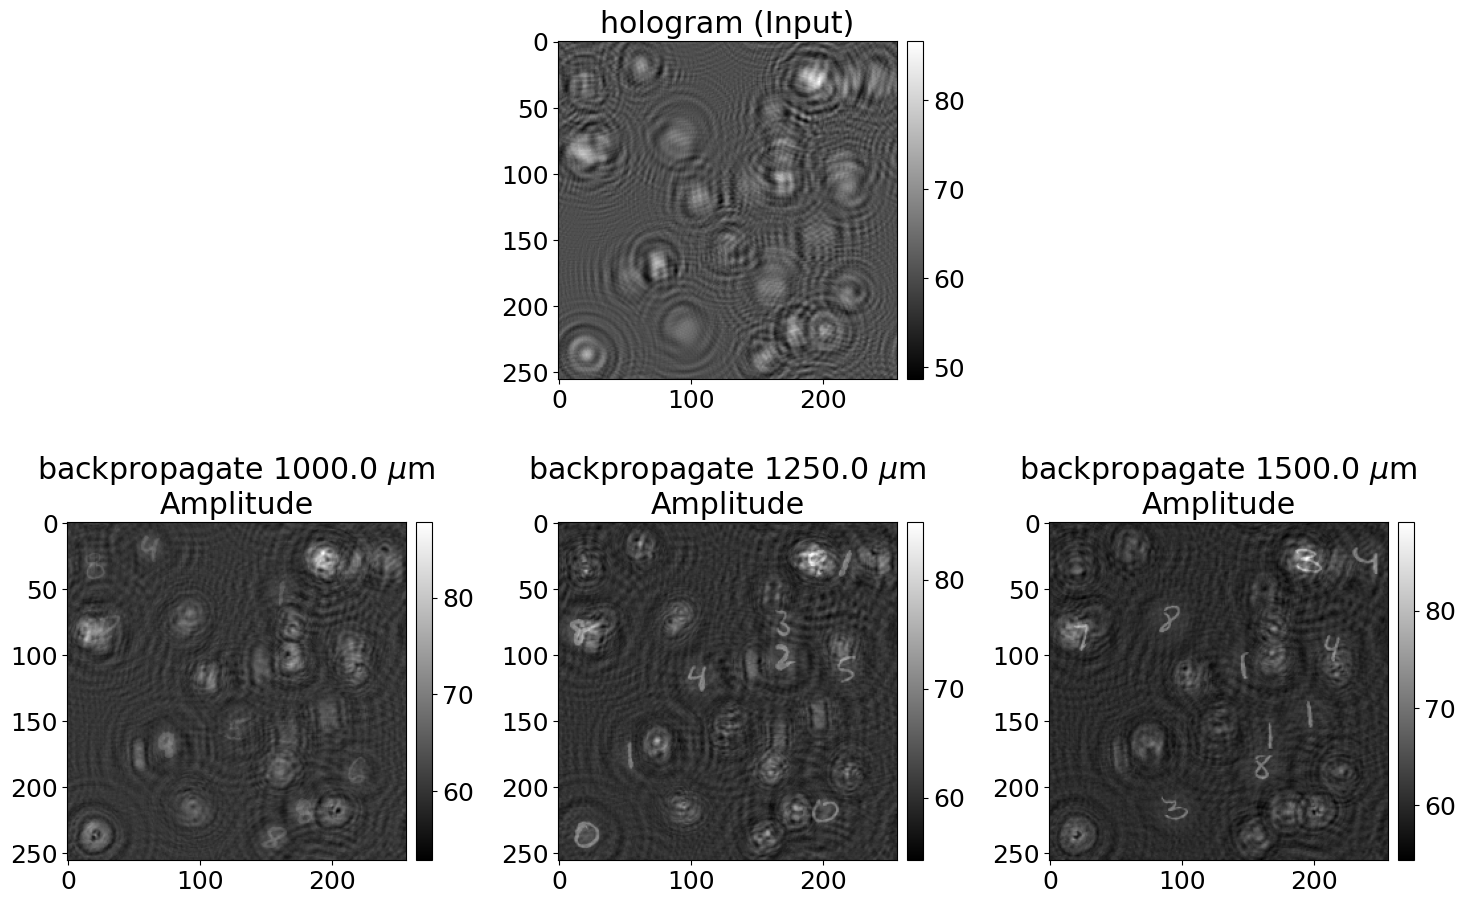

In [27]:
plt.figure(figsize=[15,14])
plt.subplot(3,3,2)
multi_obj_holo = Forward_Model(r, N, wavelength, pixel_pitch, single_depth=False)
hologram = multi_obj_holo.holo_multi_depth(input_field=input_field, z=z, z_pos_list=z, padding_size=0)
im = plt.imshow(hologram.cpu().detach().numpy()[0,0])
# plt.axis('off')
plt.gray()
plt.title('hologram (Input)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

for i in range(len(z)):
    plt.subplot(3,3,4+i)
    f_est, CTF = multi_obj_holo.asm_custom(f=hologram, z_pos=-z[i], fix_padding=True, padding=0, crop2size=True)
    f_est = torch.abs(f_est)
#     f_est = f_est - torch.min(f_est)+0.
#     f_est = f_est/torch.max(f_est)
    im = plt.imshow(f_est.cpu().detach().numpy()[0,0])
#     plt.axis('off')
    plt.title(f'backpropagate {z[i]} $\mu$m\nAmplitude')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

### Resconstructed without neural estimator

### Build U-Net architecture by PyTorch

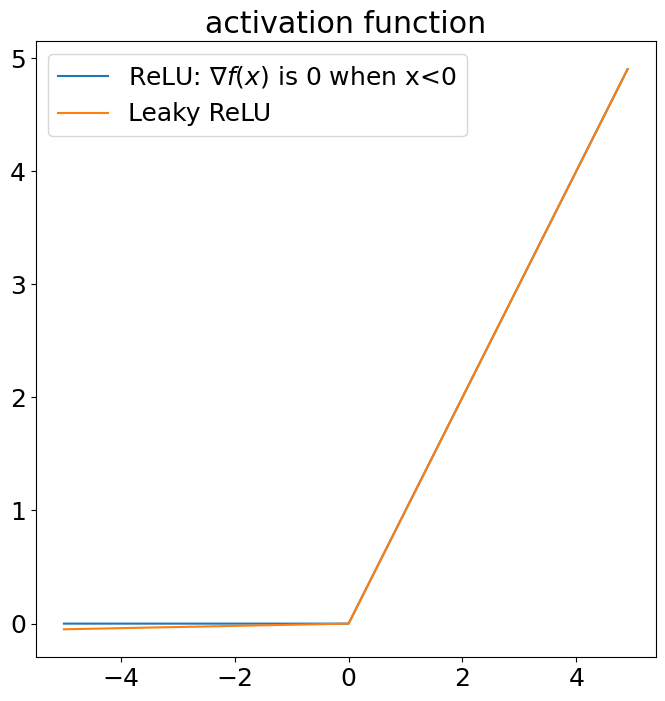

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

def relu(x):
    return np.maximum(0,x)
def Leaky_relu(x):
    return np.maximum(0.01*x,x)

x=np.arange(-5.0,5.0,0.1)
plt.plot(x, relu(x), label=r'ReLU: $\nabla f(x)$ is 0 when x<0')
plt.plot(x, Leaky_relu(x), label='Leaky ReLU')
plt.legend()
plt.title('activation function')
plt.show()

In [15]:
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, bilinear=False):
        super(UNet, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(input_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 32, bilinear)
        self.outc = OutConv(32, output_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

In [16]:
## xavier initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [17]:
def test():
    x = torch.randn((1, 1, 512, 512)).to(device='cpu', dtype=torch.float32)
    model = UNet(input_channels=1, output_channels=1)
    model = model.to(device='cpu', dtype=torch.float32)
    model.apply(init_weights)
    preds = model(x)
#     torch.save(model, 'test.pt')
    print('input:', x.shape)
    print('output:', preds.shape)
    print()
    print(summary(model, input_size=(1, 1, 512, 512), device='cpu'))

In [18]:
test()

input: torch.Size([1, 1, 512, 512])
output: torch.Size([1, 1, 512, 512])

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 1, 512, 512]          --
├─DoubleConv: 1-1                             [1, 16, 512, 512]         --
│    └─Sequential: 2-1                        [1, 16, 512, 512]         --
│    │    └─Conv2d: 3-1                       [1, 16, 512, 512]         144
│    │    └─BatchNorm2d: 3-2                  [1, 16, 512, 512]         32
│    │    └─ReLU: 3-3                         [1, 16, 512, 512]         --
│    │    └─Conv2d: 3-4                       [1, 16, 512, 512]         2,304
│    │    └─BatchNorm2d: 3-5                  [1, 16, 512, 512]         32
│    │    └─ReLU: 3-6                         [1, 16, 512, 512]         --
├─Down: 1-2                                   [1, 32, 256, 256]         --
│    └─Sequential: 2-2                        [1, 32, 256, 256]         --
│    │    └─MaxPo

change LeakReLU into Sigmoid at the last layer

In [19]:
class UNet_sigmoid(nn.Module):
    def __init__(self, input_channels, output_channels, bilinear=False):
        super(UNet_sigmoid, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(input_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 32, bilinear)
        self.outc = nn.Sequential(
            nn.Conv2d(32, self.output_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(self.output_channels),
            nn.Sigmoid())


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

In [20]:
def test():
    x = torch.randn((1, 1, 512, 512)).to(device='cpu', dtype=torch.float32)
    model = UNet_sigmoid(input_channels=1, output_channels=3)
    model = model.to(device='cpu', dtype=torch.float32)
    model.apply(init_weights)
    preds = model(x)
#     torch.save(model, 'test.pt')
    print('input:', x.shape)
    print('output:', preds.shape)
    print()
    print(summary(model, input_size=(1, 1, 512, 512), device='cpu'))

In [21]:
test()

input: torch.Size([1, 1, 512, 512])
output: torch.Size([1, 3, 512, 512])

Layer (type:depth-idx)                        Output Shape              Param #
UNet_sigmoid                                  [1, 3, 512, 512]          --
├─DoubleConv: 1-1                             [1, 16, 512, 512]         --
│    └─Sequential: 2-1                        [1, 16, 512, 512]         --
│    │    └─Conv2d: 3-1                       [1, 16, 512, 512]         144
│    │    └─BatchNorm2d: 3-2                  [1, 16, 512, 512]         32
│    │    └─ReLU: 3-3                         [1, 16, 512, 512]         --
│    │    └─Conv2d: 3-4                       [1, 16, 512, 512]         2,304
│    │    └─BatchNorm2d: 3-5                  [1, 16, 512, 512]         32
│    │    └─ReLU: 3-6                         [1, 16, 512, 512]         --
├─Down: 1-2                                   [1, 32, 256, 256]         --
│    └─Sequential: 2-2                        [1, 32, 256, 256]         --
│    │    └─MaxPo

### Reconstruction
Epoch = 25,000
Initial learning rate = 0.01
Optimizer: AdamW with xavier initialization
  

/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/15000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Current model LR: 0.01
Current lowest MSE loss = 1.8296e+00


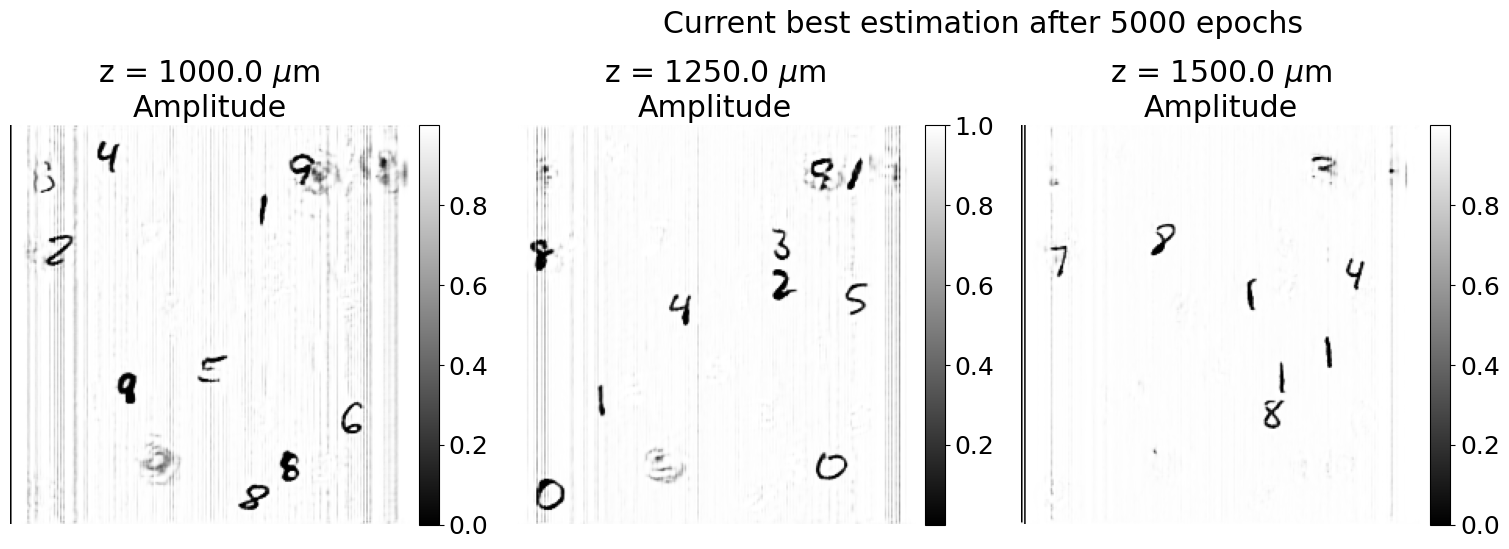

Current model LR: 0.01
Current lowest MSE loss = 9.7521e-02


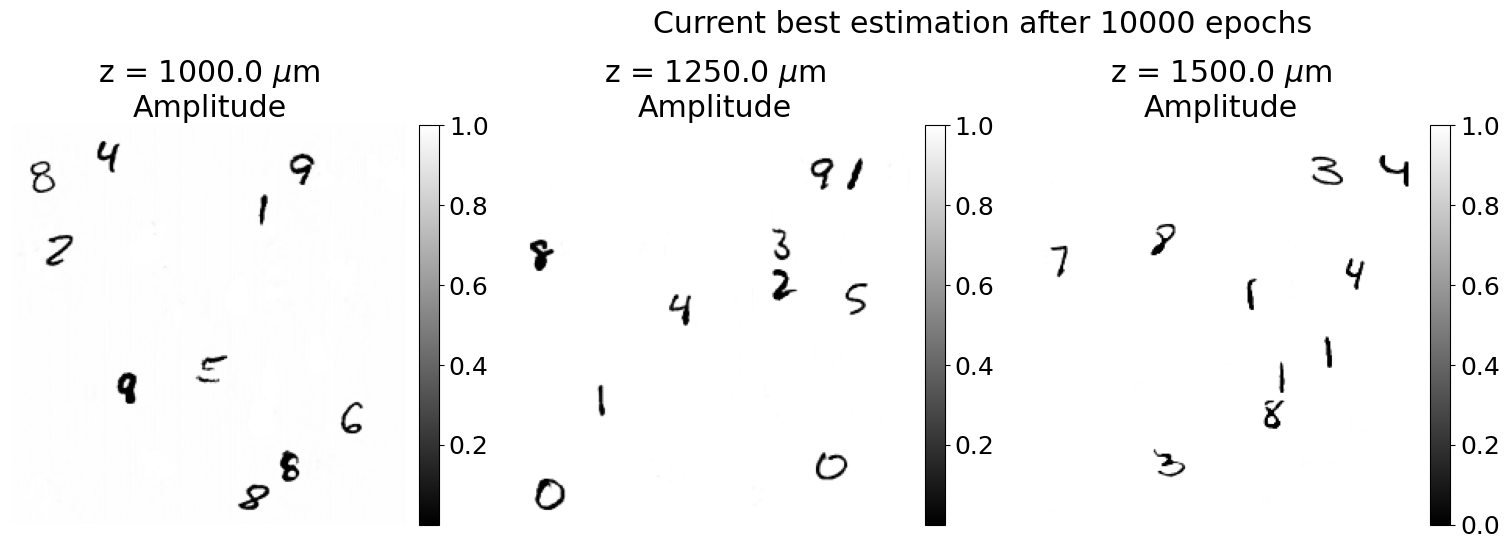

Current model LR: 0.01
Current lowest MSE loss = 5.6048e-02


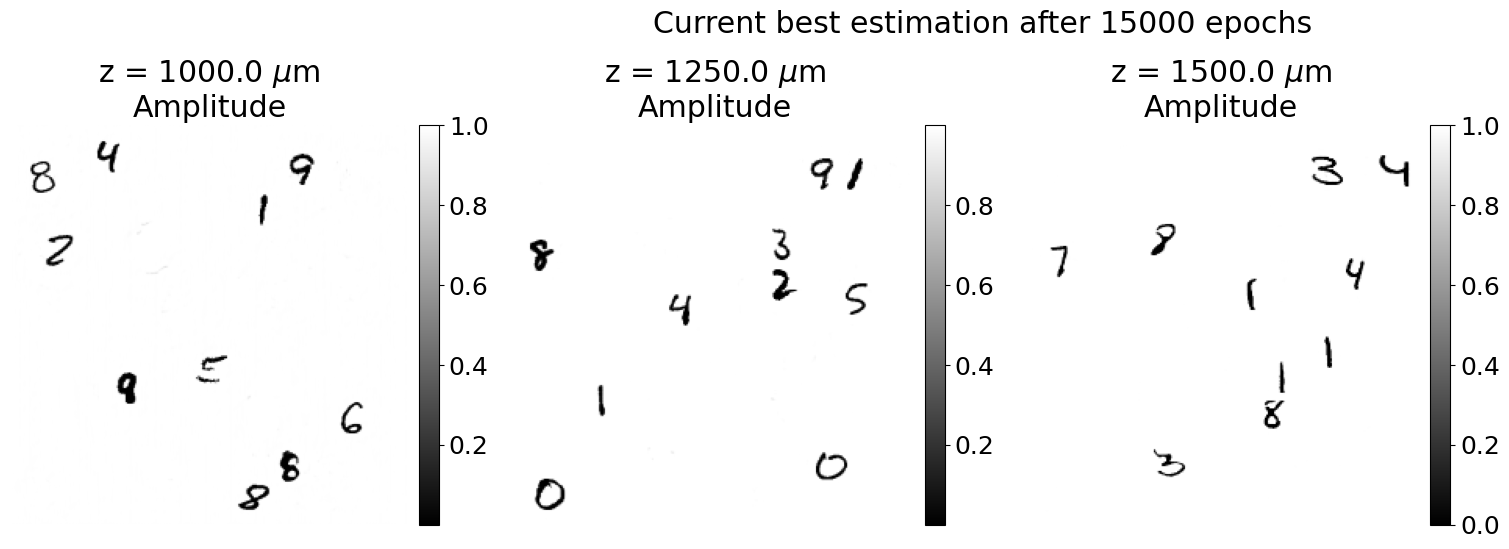

In [28]:
## Hyperparameters
LEARNING_RATE = 1e-2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 15000
Loss_list = []

## initialize model
model = UNet_sigmoid(input_channels=1, output_channels=len(z)).to(device=DEVICE, dtype=torch.float32)
model.apply(init_weights)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.002,)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100000, gamma=1, verbose=False)

scaler = torch.cuda.amp.GradScaler()
loss_fn = nn.MSELoss().type(torch.float32)
value_count = torch.zeros([N,N]).to(device=DEVICE, dtype=torch.float32)
## optimize
epoch_tqdm = tqdm(range(NUM_EPOCHS))
hologram = hologram.to(device=DEVICE, dtype=torch.float32)

for num in epoch_tqdm:

    if num+1 == 10000:
        optimizer.param_groups[0]['weight_decay'] = 0.0002

    ## forward
    with torch.cuda.amp.autocast():
        if (num+1)%500 == 0:
            noise = torch.normal(0, 0.02, size=[1,1,N,N]).to(device=DEVICE, dtype=torch.float32)
        else:
            noise = 0
        f_est = model(hologram+noise).to(device=DEVICE)

        if (num+1)%500 == 0:
            amp_coef = 0.4*np.random.random()+1.1
        else:
            amp_coef = 1
        f_est = (f_est*amp_coef).to(device=DEVICE, dtype=torch.complex64)

        hologram_est = multi_obj_holo.holo_multi_depth(input_field=f_est, z=z,
                                                       z_pos_list=z, padding_size=0)
        loss = loss_fn(hologram_est, hologram)

    ## backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()


    Loss_list.append(loss.cpu().detach().numpy())
    epoch_tqdm.set_postfix_str(f'Current lowest MSE loss = {np.min(Loss_list):.4e}, '+\
                               f'MSE loss = {Loss_list[-1]:.4e}')

    if np.min(Loss_list) == Loss_list[-1]:
        f_est_best = f_est.cpu().detach().numpy()[0]

    if (num+1)%5000 == 0:
        f_est_best_amp = np.abs(f_est_best)

        for i in range(len(z)):
            if i == 0:
                f_est_best_view = f_est_best_amp[0]/np.max(f_est_best_amp[0])
            else:
                f_est_best_view = np.concatenate((f_est_best_view,
                                                  f_est_best_amp[i]/np.max(f_est_best_amp[i])), axis=1)

        cv.imwrite(f'./single_obj_recon/{save_name_prefix}_{num+1}.png',
                   (f_est_best_view*255).astype(np.uint8))

    if (num+1)%5000 == 0:
        print('Current model LR: {0}'.format(optimizer.param_groups[0]['lr']))
#         print('Current Phase model learning rate: {0}'.format(optimizer.param_groups[0]['lr']))
        print(f'Current lowest MSE loss = {np.min(Loss_list):.4e}')

        plt.figure(figsize=[20,10])
        for i in range(len(z)):
            plt.subplot(2,4,i+1)
            im = plt.imshow(np.real(f_est_best[i]))
            plt.axis('off')
            plt.gray()
            plt.title(f'z = {z[i]} $\mu$m\nAmplitude')
            divider = make_axes_locatable(plt.gca())
            cax = divider.append_axes("right", size="5%", pad=0.1)
            plt.colorbar(im, cax=cax)

        plt.suptitle(f'Current best estimation after {num+1} epochs')
        plt.tight_layout()
        plt.show()




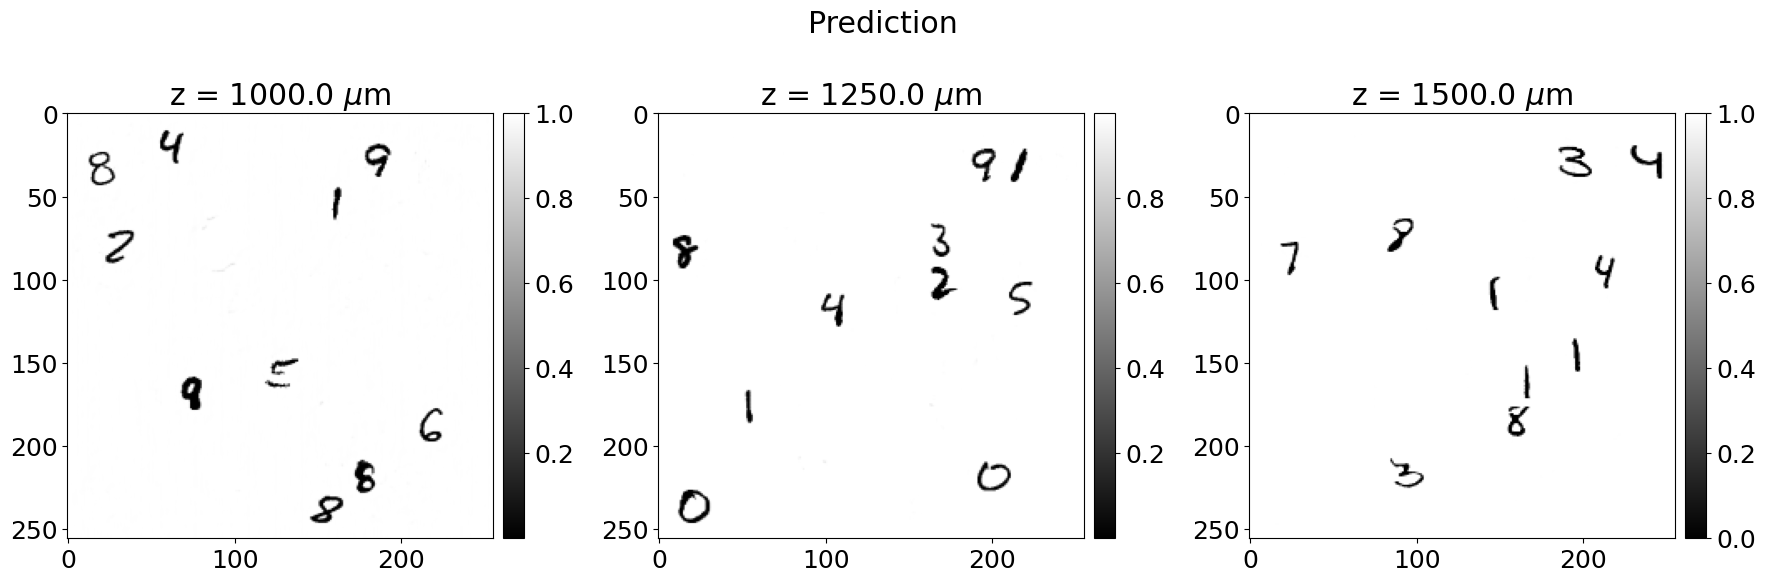

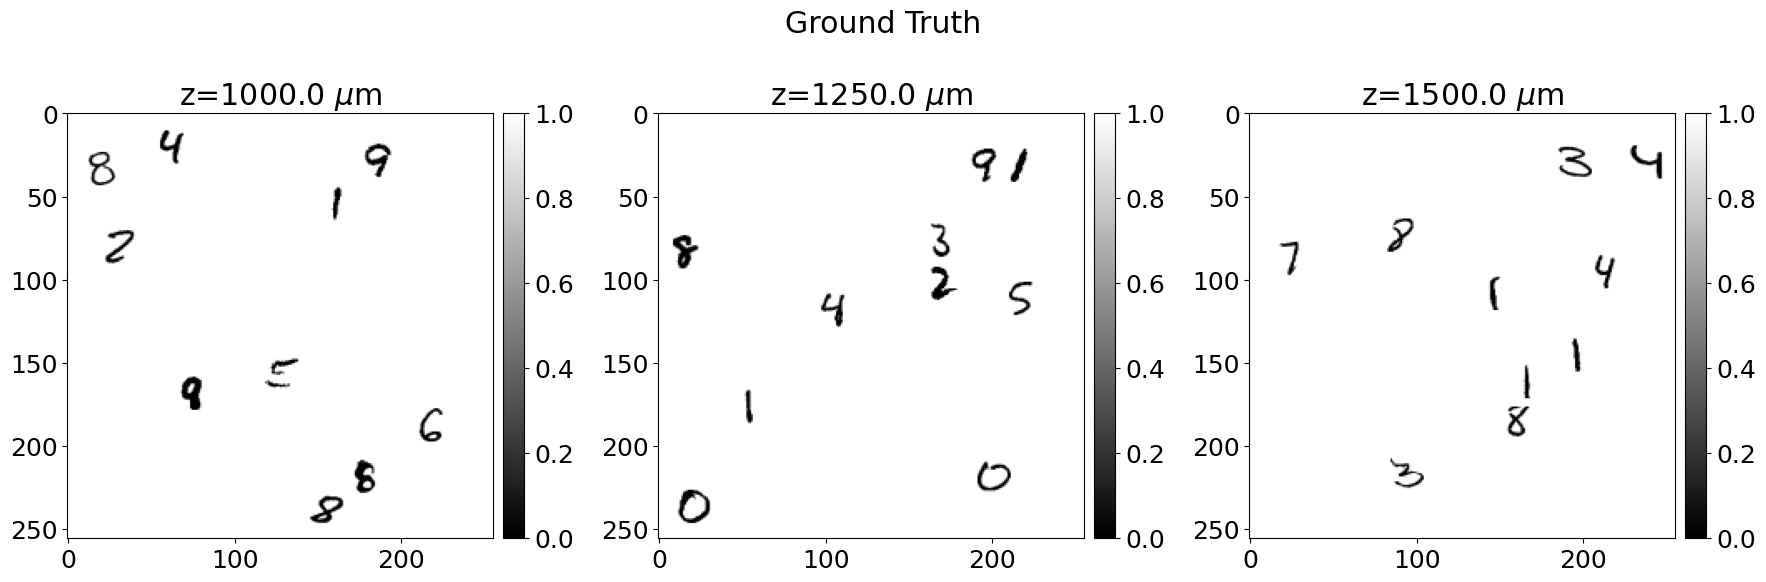

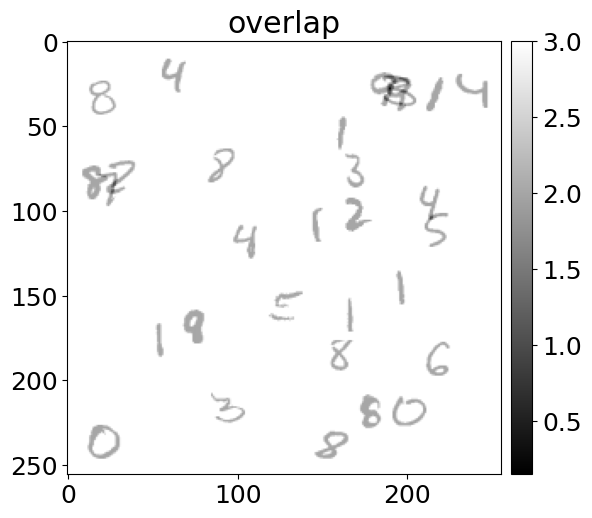

In [29]:
plt.figure(figsize=[18,6])
for i in range(len(z)):
    plt.subplot(1,3,i+1)
    im = plt.imshow(abs(f_est_best[i]))
    plt.gray()
    plt.title(f'z = {z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)

plt.suptitle('Prediction')
plt.tight_layout()
plt.savefig(f'{save_name_prefix}.png', dpi=300)
plt.show()

plt.figure(figsize=[18,6])
for i in range(len(z)):
    plt.subplot(1,3,1+i)
    im = plt.imshow(abs(input_field[0,i,...].cpu().detach().numpy()))
    plt.title(f'z={z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    plt.gray()
plt.suptitle('Ground Truth')
plt.tight_layout()
plt.show()

plt.figure()
im = plt.imshow(np.sum(abs(input_field[0,...].cpu().detach().numpy()), axis=0))
plt.title('overlap')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
plt.show()

Result

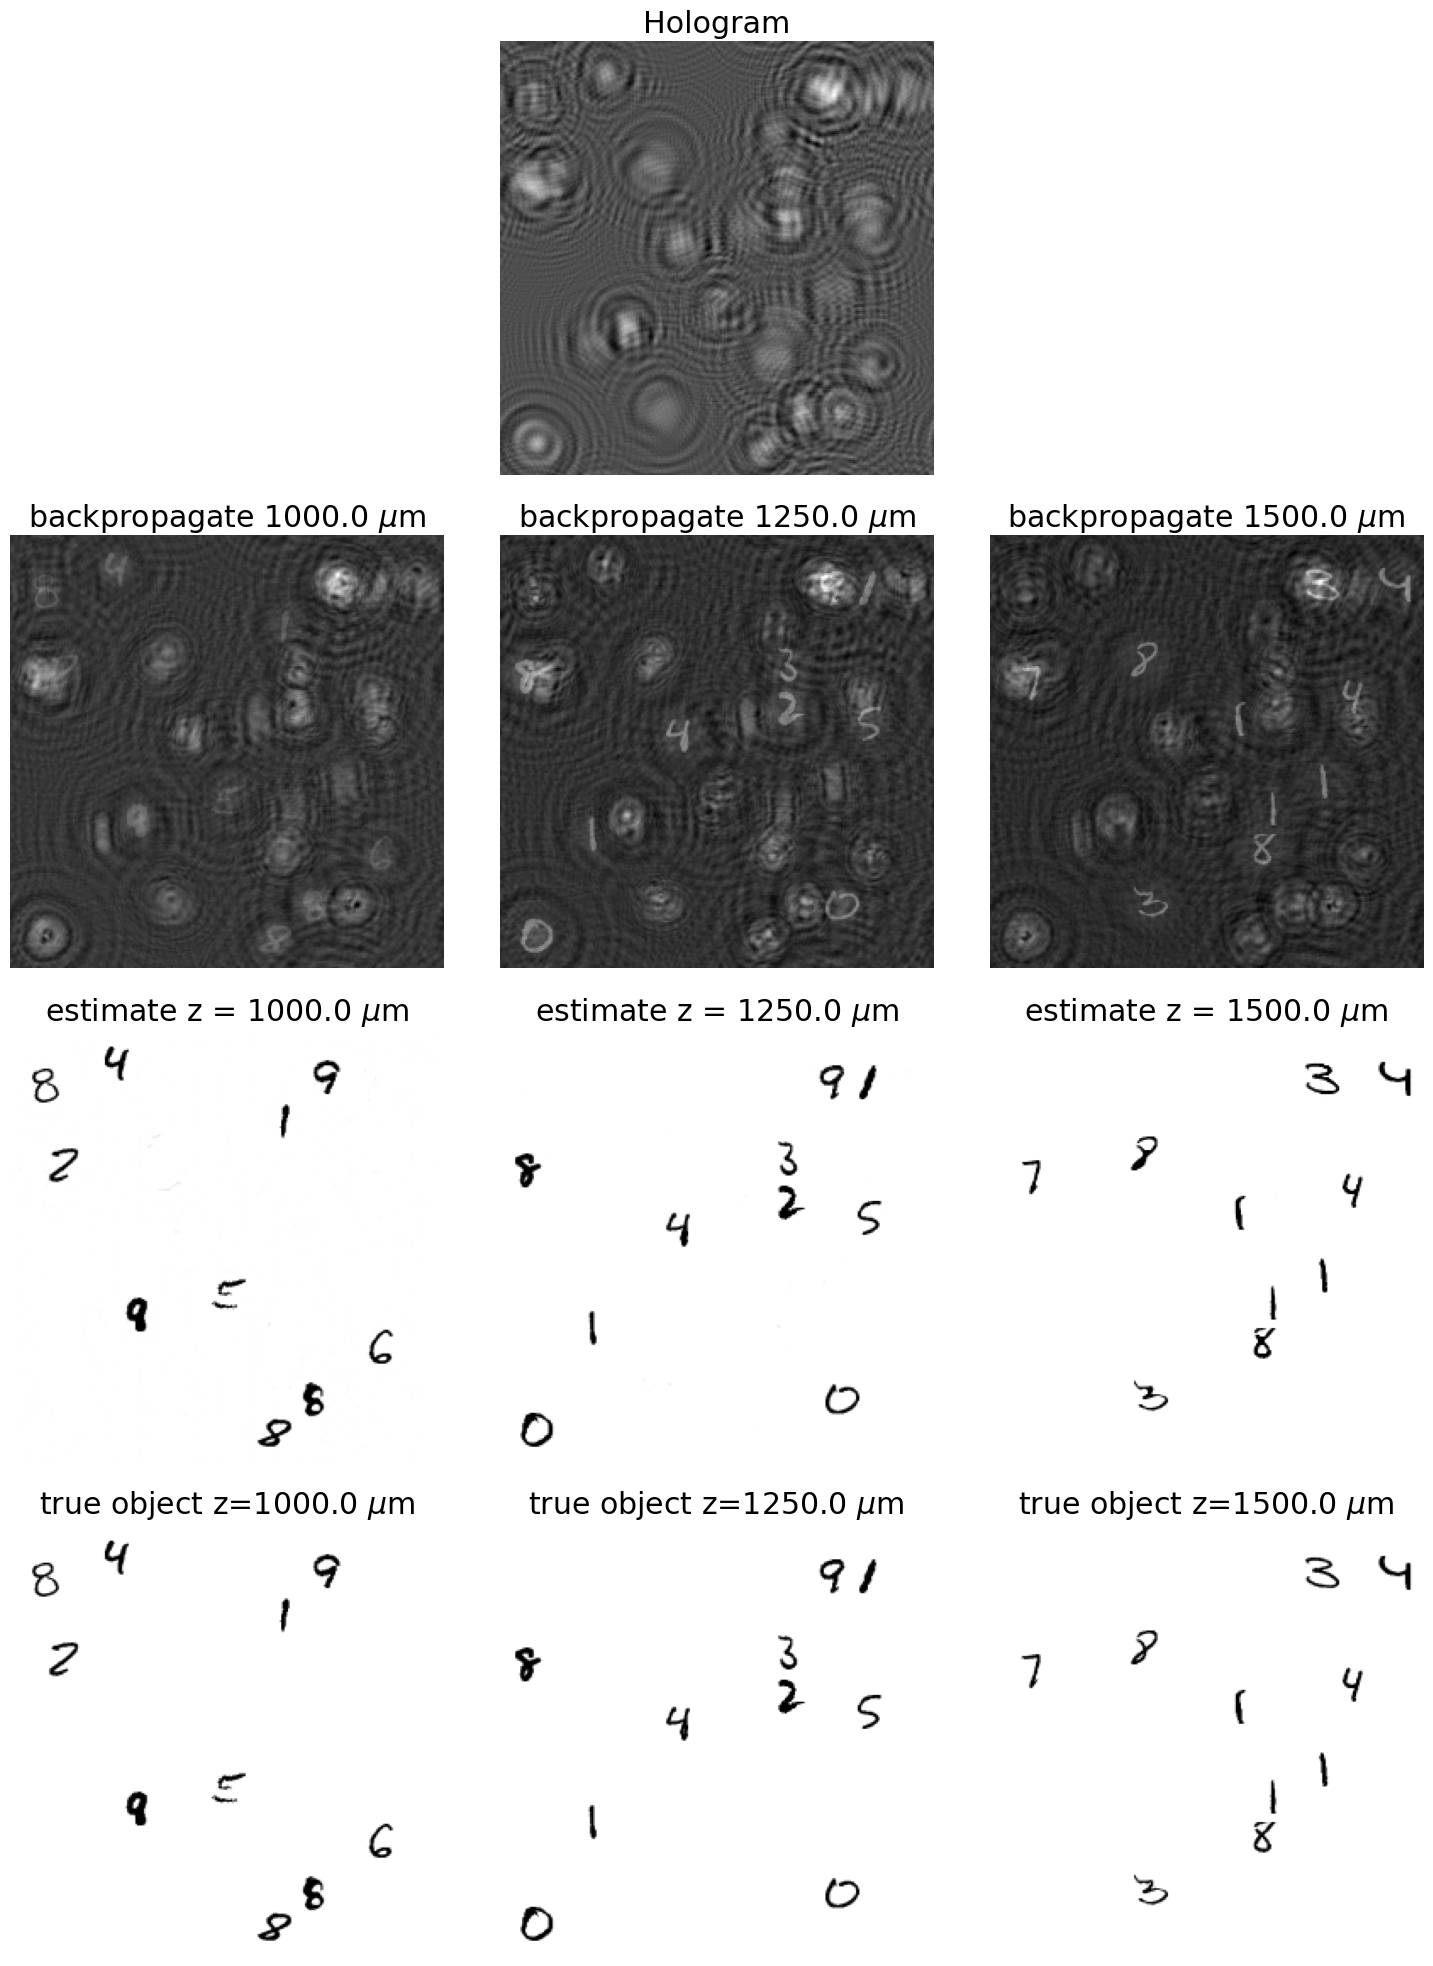

In [31]:
plt.figure(figsize=[15,20])
plt.subplot(4,3,2)
multi_obj_holo = Forward_Model(r, N, wavelength, pixel_pitch, single_depth=False)
hologram = multi_obj_holo.holo_multi_depth(input_field=input_field, z=z, z_pos_list=z, padding_size=0)
im = plt.imshow(hologram.cpu().detach().numpy()[0,0])
plt.axis('off')
plt.gray()
plt.title('Hologram')
divider = make_axes_locatable(plt.gca())
#cax = divider.append_axes("right", size="5%", pad=0.1)
#plt.colorbar(im, cax=cax)

for i in range(len(z)):
    plt.subplot(4,3,4+i)
    f_est, CTF = multi_obj_holo.asm_custom(f=hologram, z_pos=-z[i], fix_padding=True, padding=0, crop2size=True)
    f_est = torch.abs(f_est)
#     f_est = f_est - torch.min(f_est)+0.
#     f_est = f_est/torch.max(f_est)
    im = plt.imshow(f_est.cpu().detach().numpy()[0,0])
    plt.axis('off')
    plt.title(f'backpropagate {z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
    #cax = divider.append_axes("right", size="5%", pad=0.1)
    #plt.colorbar(im, cax=cax)


for i in range(len(z)):
    plt.subplot(4,3,i+7)
    im = plt.imshow(abs(f_est_best[i]))
    plt.gray()
    plt.axis('off')
    plt.title(f'estimate z = {z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
  #  cax = divider.append_axes("right", size="5%", pad=0.1)
   # plt.colorbar(im, cax=cax)



for i in range(len(z)):
    plt.subplot(4,3,10+i)
    im = plt.imshow(abs(input_field[0,i,...].cpu().detach().numpy()))
    plt.axis('off')
    plt.title(f'true object z={z[i]} $\mu$m')
    divider = make_axes_locatable(plt.gca())
   # cax = divider.append_axes("right", size="5%", pad=0.1)
   # plt.colorbar(im, cax=cax)
    plt.gray()

plt.tight_layout()

plt.savefig('multiplaneCompressive.pdf')

PSNR

data below is for z= stacked, 1000, 1250, and 1500 μm, respectively. From the values displayed we can see that the estimated images are a very good approximation to the ground truth. The structural similarity index measure for all different z distances were all very high as well.

In [30]:
psnr_comparsion = psnr(
            image_true=abs(input_field[0].cpu().detach().numpy()),
            image_test=abs(f_est_best),
            data_range=1.0
        )
psnr_comparsion

39.6889357408167

In [64]:
gt = np.abs(input_field[0,0,:].cpu().detach().numpy())
psnr_ssim(gt, f_est_best[0].astype(np.float32))

<ipython-input-64-c5a419b6afa0>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  psnr_ssim(gt, f_est_best[0].astype(np.float32))


(46.54999938439471, 0.9974638551066837)

In [65]:
gt = np.abs(input_field[0,1,:].cpu().detach().numpy())
psnr_ssim(gt, f_est_best[1].astype(np.float32))

<ipython-input-65-4ea5fa4b3f7f>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  psnr_ssim(gt, f_est_best[1].astype(np.float32))


(46.86247965738026, 0.9991801775825955)

In [66]:
gt = np.abs(input_field[0,2,:].cpu().detach().numpy())
psnr_ssim(gt, f_est_best[2].astype(np.float32))

<ipython-input-66-8839628c2b00>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  psnr_ssim(gt, f_est_best[2].astype(np.float32))


(35.535400343454214, 0.9987105150843173)